In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
#from tabulate import tabulate

In [2]:
#Web Scraping - https://pythonprogramminglanguage.com/web-scraping-with-pandas-and-beautifulsoup/
res = requests.get("http://www.fedearroz.com.co/new/precios.php")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
#print( tabulate(df[0], headers='keys', tablefmt='psql') )

In [3]:
#Data Wrangling
arroz=df[0]
#arroz.columns = arroz.iloc[0]
#arroz = arroz.set_index(['Mes'])
#arroz = arroz.drop(['Mes'])
#arroz = arroz.replace(["Enero",'Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'],['1','2','3','4','5','6','7','8','9','10','11','12'])
#arroz = arroz.reset_index()
arroz['Mes'] = ['1','2','3','4','5','6','7','8','9','10','11','12']
arroz = pd.melt(arroz, id_vars=['Mes'],var_name='Year',value_name='Price')
arroz = arroz.rename(columns={'Mes': 'Month'})
arroz['Year'] = arroz['Year'].astype(int)
arroz['Month'] = arroz['Month'].astype(int)
arroz = arroz.dropna()

#pd.to_datetime((df.Y*10000+df.M*100+df.D).apply(str),format='%Y%m%d')
arroz['Date']=pd.to_datetime((arroz.Year*10000+arroz.Month*100+1).apply(str),format='%Y%m%d')

arroz=arroz[['Date','Price']]
arroz['Price']=arroz['Price']/1000

arroz = arroz.set_index('Date')

In [4]:
arroz.head(12)

,Price
Date,
2011-01-01,918.571
2011-02-01,939.010
2011-03-01,963.438
2011-04-01,987.905
2011-05-01,1059.719
2011-06-01,902.833
2011-07-01,855.557
2011-08-01,927.400
2011-09-01,977.519


In [5]:
arroz.tail(8)

,Price
Date,
2018-10-01,947.000
2018-11-01,947.857
2018-12-01,946.429
2019-01-01,961.286
2019-02-01,985.000
2019-03-01,993.571
2019-04-01,1010.408
2019-05-01,1024.171


/home/drivera/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

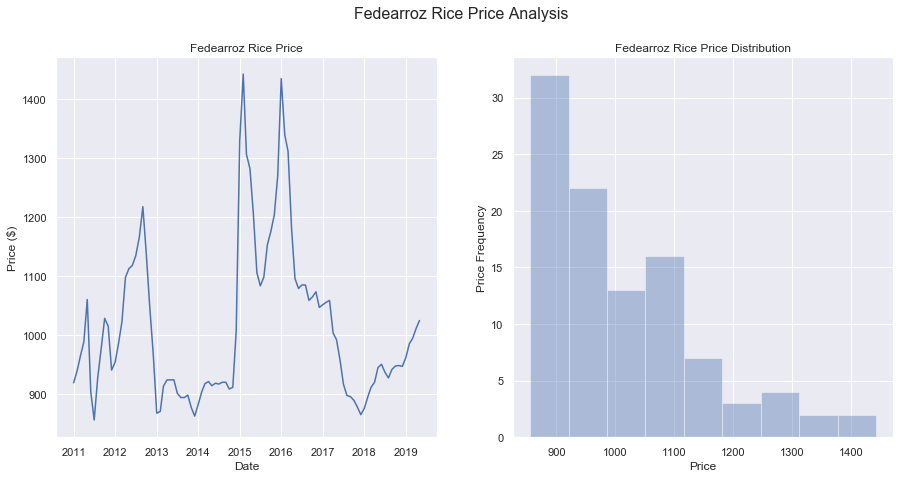

In [6]:
#Timeseries and Distribuition Plot

fig = plt.figure()
sns.set()

f, axs = plt.subplots(2,2,figsize=(15,7))

plt.subplot(121)
sns.lineplot(x=arroz.index, 
             y="Price", 
             data=arroz)
plt.title('Fedearroz Rice Price')
plt.ylabel('Price ($)')

plt.subplot(122)
sns.distplot(arroz.Price,
                    kde=False,
                    color="b")
plt.title('Fedearroz Rice Price Distribution')
plt.ylabel('Price Frequency')

plt.suptitle('Fedearroz Rice Price Analysis', fontsize=16)
plt.show()


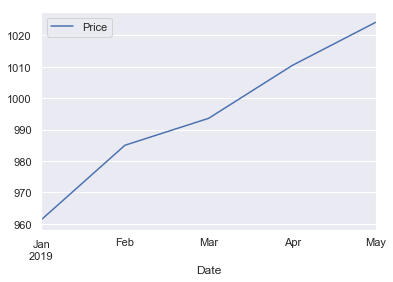

In [7]:
arroz2018 = arroz['2019']
arroz2018.plot()

In [8]:
quarterly = arroz['Price'].resample('Q')
quarterly_mean = quarterly.mean()

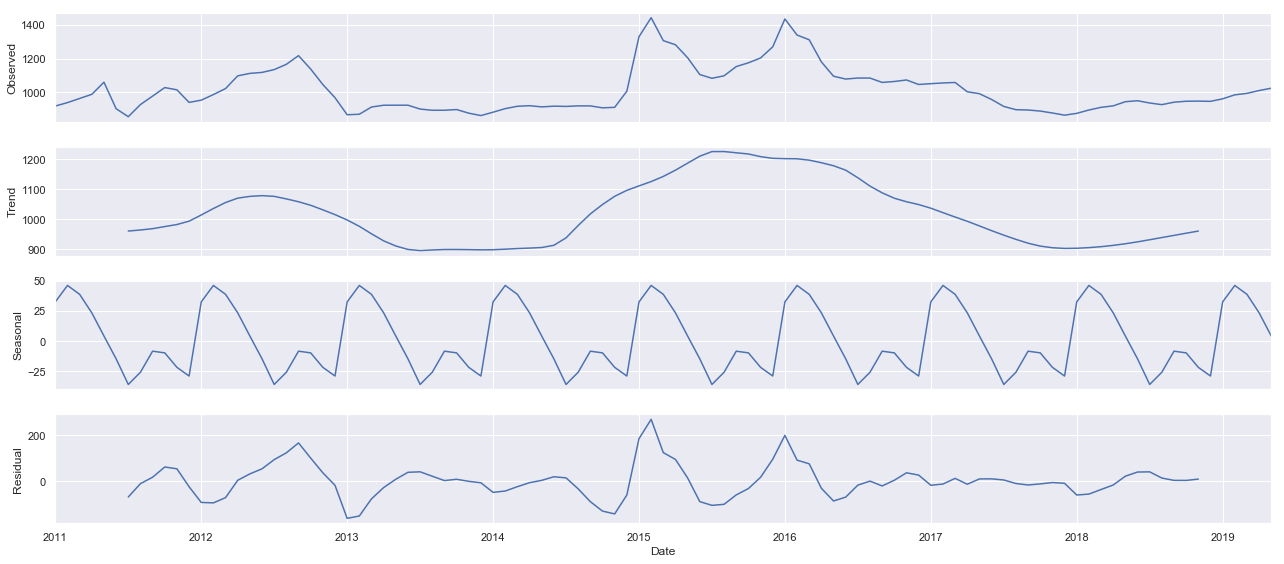

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(arroz['Price'], model='additive')
fig = decomposition.plot()
plt.show()

In [10]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
            

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [11]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(arroz['Price'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

            

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1671.8094397432044


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequen

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1383.079336170475
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1164.356511936485


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:990.8468531897647
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1177.9706262781042


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1150.1832672613848
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1022.272205099249


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1005.0606839929895
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1527.6856071485677


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1257.56348441153
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1059.8081376722519


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:898.9751689095622


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1084.2816951107743


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1064.8358638071925
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:940.510804942144


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:900.878148092606
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1089.0470954847976
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:945.6768810954867
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:993.1232659128092


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:843.9277319008082
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:959.468635928703
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:947.6684901942925
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:863.4522396009155


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:844.7420883404728
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1064.7860492928726
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:924.1613747969562


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:976.785014205488


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:819.9478901934157
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:947.2410816513282


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:926.058426938334


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:853.6132612109323


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:821.3133245369423
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1101.1321044177275


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:957.9141463691319
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1002.0070113395008


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:852.6979538608463
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:961.4209848376458


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:959.9137982895634
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:862.6238608323499


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:854.1926193582954
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1076.8991064542606


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:936.3402569912024
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:983.3951570122117


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:826.0794907271431
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:949.0785348834283


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:938.2834162344623


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:850.7981870381215


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:827.4061709483361
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1078.3830183953846
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:936.336540428912
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:988.2655919498


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:833.6695773625013
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:938.9577819495069
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:938.3301854834261


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:845.9271684161436


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:832.7956743043235
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1066.7309046138976


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:926.1434670682781
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:977.4528105158364


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:821.9048956095993
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:939.0146794710108


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:928.0486469795252


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:845.3844575572491


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:823.8181787087551


In [17]:
mod = sm.tsa.statespace.SARIMAX(arroz['Price'],
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4762      0.067      7.055      0.000       0.344       0.608
ma.S.L12      -1.0000      0.083    -12.089      0.000      -1.162      -0.838
sigma2      2803.0825   2.95e-05    9.5e+07      0.000    2803.082    2803.083


/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


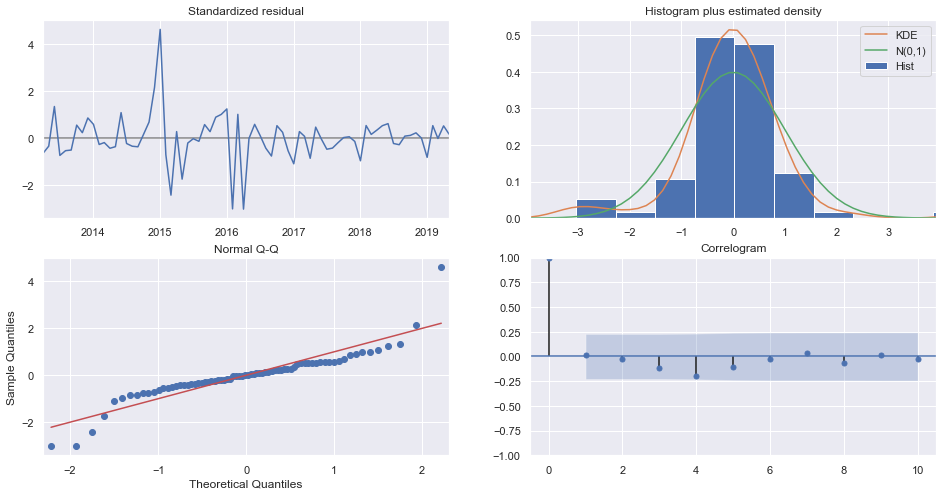

In [18]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

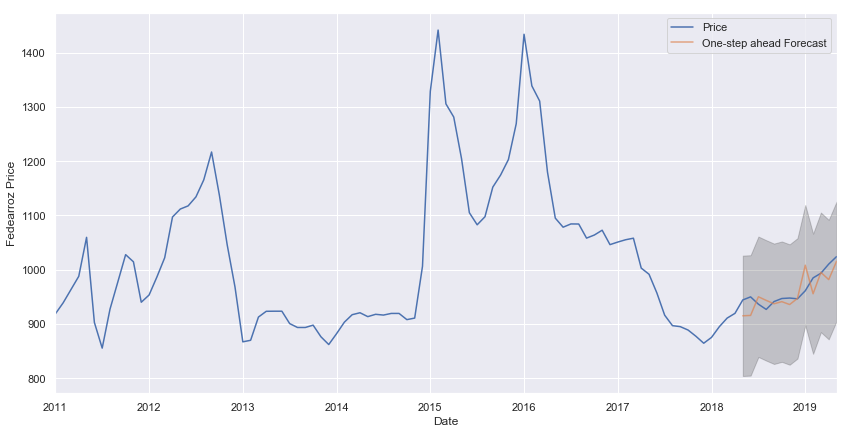

In [19]:
pred = results.get_prediction(start=pd.to_datetime(arroz.index[len(arroz)-12-1]), dynamic=False)
pred_ci = pred.conf_int()

ax = arroz.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Fedearroz Price')
plt.legend()

plt.show()

/home/drivera/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


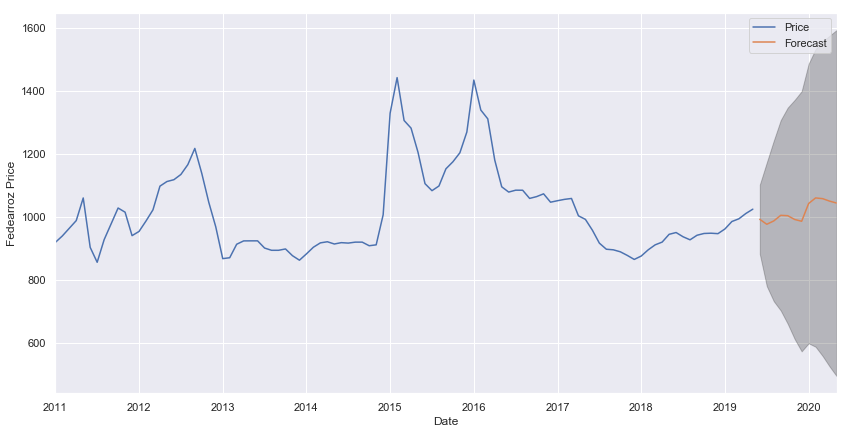

In [20]:
#Producing and visualizing forecasts

pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()

ax = arroz.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Fedearroz Price')

plt.legend()
plt.show()

In [21]:
Arroz_Forecast = pd.DataFrame(pred_uc.predicted_mean)
Arroz_Forecast.columns = ['Price']
Arroz_Forecast

,Price
2019-06-01,991.906825
2019-07-01,976.186945
2019-08-01,986.788115
2019-09-01,1004.622867
2019-10-01,1003.491002
2019-11-01,991.452410
2019-12-01,985.741548
2020-01-01,1042.150898
2020-02-01,1059.847497
2020-03-01,1057.610367
